<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Connect Google Drive

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

In [14]:
# import os

# # Change to the directory where project is located
# os.chdir('/content/drive/MyDrive/College/MSc/2nd Semester/Deep Learning/project')

# # Verify that we changed the directory
# print("Changed directory to:", os.getcwd())

## 1.2 Import Libraries

In [15]:
# # # Google Colab
# !pip install keras_cv

In [16]:
import pandas as pd
import zipfile
import pickle
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import regularizers
from classes import *
from functions import *

In [17]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import optimizers

## 1.3 Import Dataset

The amount of data we have is not supported by GitHub (where we have our project stored). The solution is: create a folder named data and allocate the rare_species file inside it. The gitignore file makes sure this folder is not used when we are pulling or pushing changes but everyone needs to have it on their machines locally. A random seed was used to ensure that the splits stay the same. 

In [18]:
# # Google Colab

# # Define the path to the zip file and the extraction folder
# zip_path = Path("../data/rare_species.zip")

# # Get the directory where the zip file is located
# extract_path = Path("../data/rare_species")

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [19]:
# Import Metadata
metadata_path = Path("../data/rare_species/metadata.csv")
df = pd.read_csv(metadata_path)
df.head()

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...


In [20]:
df.shape # 11983 images

(11983, 7)

<div class="alert alert-block alert-success">

# **2.** Preprocessing

<div>

In [21]:
#Load the DataFrames from the .pkl files
with open("../data/train_df.pkl", "rb") as f:
     train_df = pickle.load(f)

with open("../data/valid_df.pkl", "rb") as f:
     val_df = pickle.load(f)

with open("../data/test_df.pkl", "rb") as f:
     test_df = pickle.load(f)

with open("family_encoder.pkl", "rb") as f:
     family_encoder = pickle.load(f)

with open("phylum_encoder.pkl", "rb") as f:
     phylum_encoder = pickle.load(f)

In [22]:
batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
image_size = (224, 224)

preprocess = Preprocessor_with_phylum(image_size=image_size, batch_size=batch_size)

In [23]:
# identify the minority class
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

# Load training data with oversampling and mixup augmentation
train_ds, family_class_names, phylum_class_names = preprocess.load_img(train_df, minority_class=minority_class, family_encoder=family_encoder, phylum_encoder=phylum_encoder, shuffle=True, augment='mixup', oversampling=True)
# train_ds_sampled, class_names = preprocess.load_img(data_dir="../data/rare_species/train_sampled", minority_class=minority_class, augment=None, oversampling=True)

# Load validation and test data without augmentation or oversampling
val_ds, _, _ = preprocess.load_img(val_df, minority_class=minority_class, family_encoder=family_encoder, phylum_encoder=phylum_encoder, shuffle=False, augment=None, oversampling=False)
test_ds, _, _ = preprocess.load_img(test_df, minority_class=minority_class, family_encoder=family_encoder, phylum_encoder=phylum_encoder, shuffle=False, augment=None, oversampling=False)

In [24]:
# num_images = 16 ##
# rows, cols = 4, 4 ##

# plot_batch(train_ds, class_names=class_names, num_images=num_images, rows=rows, cols=cols)

<div class="alert alert-block alert-success">

# **3.** Models

<div>

## ResNet50 + Phylum

### Model

In [25]:
        #     ┌────────────────────┐
        #     │  image_input (224x224x3)
        #     └─────────┬──────────┘
        #               │
        #      Pretrained ResNet50 (no top)
        #               │
        # GlobalAveragePooling2D (→ 2048)
        #   - 2048 = number of filters in the final convolutional layer of ResNet50.
        #   - GlobalAveragePooling2D averages over 7×7 spatial grid, giving a single 2048-element feature vector per image.

        #               │
        #               ▼
        #        ┌───────────────┐
        #        │ image features│
        #        └──────┬────────┘
        #               │
        #     ┌─────────▼────────┐
        #     │ phylum_input (5,)│
        #     └─────────┬────────┘
        #               │
        #       Concatenate (→ 2048+5)
        #               │
        #       Dense(256, ReLU)
        #               │
        #          Dropout(0.3)
        #               │
        #    Dense(202, Softmax Output)
        #               │
        #               ▼
        #    Final prediction (family)

In [26]:
# Image input pipeline
image_input = Input(shape=(224, 224, 3), name="image_input")  # Input for RGB image
base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=image_input)  # Pretrained ResNet without final dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert 4D feature map to 2D vector (batch_size, 2048)

# Phylum input (one-hot or multi-class vector with 5 classes)
phylum_input = Input(shape=(5,), name="phylum_input")  # Input for phylum-level info

# Combine image and phylum features
combined = Concatenate()([x, phylum_input])  # Concatenate the two inputs: (batch_size, 2048 + 5)
combined = Dense(256, activation='relu')(combined)  # Fully connected layer
combined = Dropout(0.5)(combined)  # Dropout for regularization
output = Dense(202, activation='softmax')(combined)  # Final classification layer (202 family classes)

# Define the model
model = Model(inputs=[image_input, phylum_input], outputs=output)

# Compile with metrics
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_macro"),
    F1Score(average="weighted", name="f1_weighted"),
    TopKCategoricalAccuracy(k=5, name="top5_accuracy")
]

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)

# Print the model summary
# model.summary()

In [ ]:
# Initialize the experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="resnet50_with_phylum",
    resume=False,
)

# Define the learning rate scheduler function
initial_lr = 1e-4
final_lr = 1e-5
n_epochs = 70

my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)

# Default callbacks
# ExperimentLogger,  # Log experiment results after each epoch
# ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# Define additional callbacks
callbacks_additional = [
    lr_callback,
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

# Run the experiment
# resume=False means start from scratch, resume=True means continue from last checkpoint)
# callbacks=None use default callbacks (created in the Experiment class)
history = experiment.run_experiment(callbacks=callbacks_additional, epochs=50)

Epoch 1/50


2025-04-21 20:50:00.755892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-21 20:50:19.947414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 1029 of 8388
2025-04-21 20:50:39.947188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 2885 of 8388
2025-04-21 20:50:49.966078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 3953 of 8388


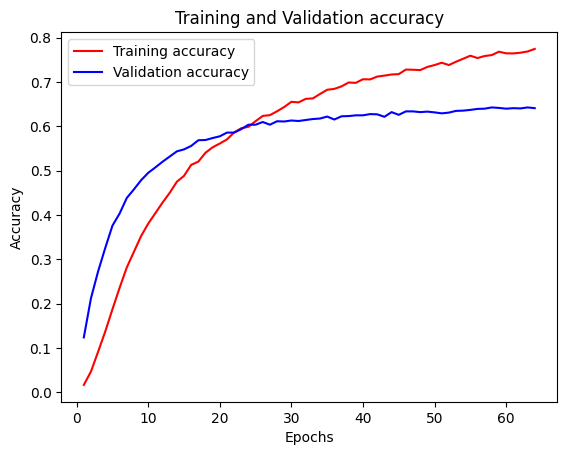

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
plot_model_acc(num_epochs=64, train_acc=acc_train, val_acc=acc_val)

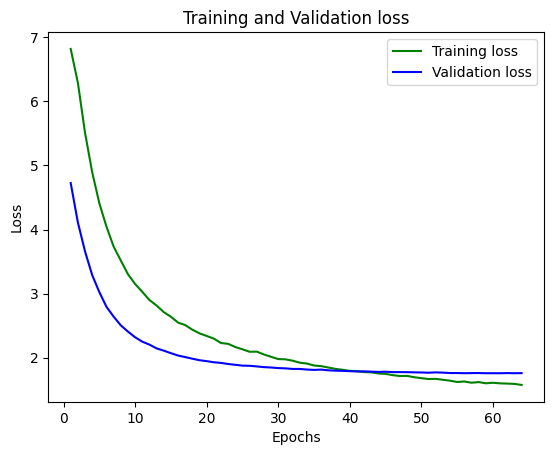

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plot_model_loss(num_epochs=64, train_loss=loss_train, val_loss=loss_val)

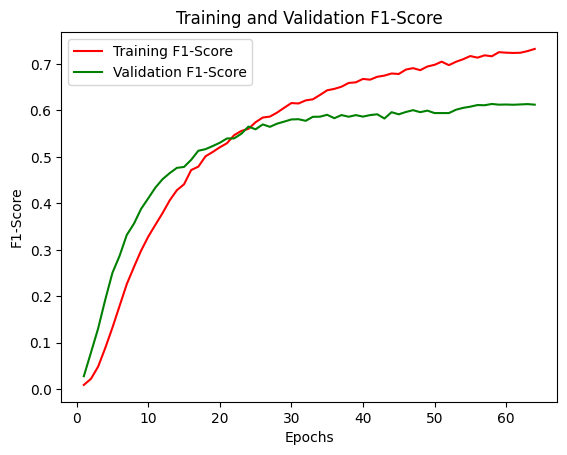

In [ ]:
x_axis = range(1,64+1)
plt.plot(x_axis, history.history['f1_score'], 'r', label='Training F1-Score')
plt.plot(x_axis, history.history['val_f1_score'], 'g', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

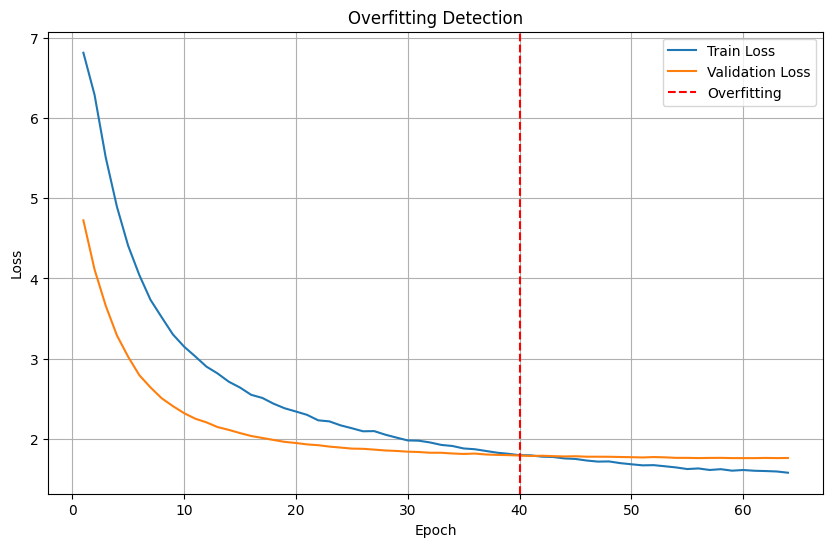

In [ ]:
epochs = range(1, len(loss_train) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train, label='Train Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.axvline(x=40, color='r', linestyle='--', label='Overfitting')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Overfitting Detection')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
epochs = range(1, len(loss_train) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train, label='Train Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.axvline(x=40, color='r', linestyle='--', label='Overfitting')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Overfitting Detection')
plt.legend()
plt.grid(True)
plt.show()

### Fine-tune

References: https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=pt-br

In [ ]:
model_ft = load_model("project/resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_until_65.keras", compile=False)

In [ ]:
trainable = False
for layer in model_ft.layers:
    if "conv5_block1_1_conv" in layer.name:
        trainable = True
    layer.trainable = trainable

model_ft.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=metrics
)

In [ ]:
experiment = Experiment(
    model=model_ft,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="resnet50_with_preprocessing_finetuning_phase_v2",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_finetune = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]
    
# Run the experiment
history_finetune = history = experiment.run_experiment(callbacks=callbacks_additional, epochs=15)

No checkpoint found, starting from scratch.
Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.5676 - auc: 0.7717 - f1_score: 0.4523 - loss: 2.3972

2025-04-15 21:50:12.540146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 140s 389ms/step


2025-04-15 21:52:34.239698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 279ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 352s 987ms/step - accuracy: 0.5675 - auc: 0.7717 - f1_score: 0.4523 - loss: 2.3974 - val_accuracy: 0.5582 - val_auc: 0.9557 - val_f1_score: 0.4552 - val_loss: 2.0267 - learning_rate: 9.5499e-06
Epoch 2/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.6191 - auc: 0.7738 - f1_score: 0.5066 - loss: 2.1776

2025-04-15 21:56:38.307295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


350/350 ━━━━━━━━━━━━━━━━━━━━ 118s 337ms/step


2025-04-15 21:58:37.486777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 289ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.6191 - auc: 0.7738 - f1_score: 0.5067 - loss: 2.1777 - val_accuracy: 0.5698 - val_auc: 0.9564 - val_f1_score: 0.4686 - val_loss: 1.9861 - learning_rate: 9.1201e-06
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.6494 - auc: 0.7774 - f1_score: 0.5321 - loss: 2.0448

2025-04-15 22:03:07.725312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 86/350 ━━━━━━━━━━━━━━━━━━━━ 1:46 403ms/step

It's already overfiting. Lets do hyperband tuner in this fine tuning phase.

### Fine tune with hyperband tuner

In [ ]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

In [ ]:
model_ft = load_model("fr_resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_70.keras", compile=False)

In [ ]:
len(model_ft.layers)

179

In [ ]:
import keras_tuner as kt

In [ ]:
def model_builder(hp):
    number_layers_unfreeze = hp.Int('number_layers_unfreeze', min_value = 1, max_value=15, step=1)

    trainable = False
    for layer in model_ft.layers:
        layer.trainable = trainable

    if number_layers_unfreeze>0:
        for layer in model_ft.layers[-number_layers_unfreeze:]:
            layer.trainable = True

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-6, 1e-7])

    model_ft.compile(optimizer=keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
                    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=metrics)

    return model_ft

In [ ]:
tuner = kt.Hyperband(
    hypermodel=model_builder,
    objective=kt.Objective("val_loss", direction="min"),  # ou "val_f1_score", direction="max"
    max_epochs=45,
    factor=3,
    hyperband_iterations=1,
    seed=42,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    directory='project/project',
    project_name='fr19_hyperband_finetune_resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_70'
)

In [ ]:
callbacks = [EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)]

In [ ]:
tuner.search(
    x=train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)

Trial 30 Complete [04h 51m 58s]
val_loss: 1.7993829250335693

Best val_loss So Far: 1.7790106534957886
Total elapsed time: 17h 36m 53s

Search: Running Trial #31

Value             |Best Value So Far |Hyperparameter
12                |4                 |number_layers_unfreeze
1e-06             |1e-07             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round



KeyboardInterrupt: 

**RUN 1**: The first run of the hyperband tuner showed that a small number of layers to unfreeze + small learning rates are better, so the maximum number of layers to unfreeze will be 15 and we will try a smaller value of learning rate